# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs using the `dnd_analysis.py` module. We'll load campaign data from `data-labels.json`, select a specific campaign for analysis, and perform various analyses to understand player engagement patterns and campaign dynamics.

## 🎯 Campaign Selection

**NEW: User-Selectable Campaign Analysis**
- This notebook now analyzes campaigns from the `data-labels.json` dataset
- **Change the `CAMPAIGN_INDEX` in the Configuration cell** to analyze different campaigns
- The dataset contains hundreds of campaigns - you can analyze any of them!
- All analysis functions work with the selected campaign data

## Table of Contents
1. [Configuration & Campaign Selection](#config)
2. [Data Loading and Preparation](#loading)
3. [Time Interval Analysis](#intervals)
4. [Cumulative Post Analysis](#cumulative)
5. [Player and Character Growth](#growth)
6. [Post Length Analysis](#lengths)
7. [Paragraph Action Analysis](#action-analysis)
8. [Character Mention Analysis](#mentions)
9. [Dice Roll Analysis](#dice-rolls)
10. [Summary Report](#summary)

In [3]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
from pathlib import Path
warnings.filterwarnings('ignore')
#sys.path.append('..')

import analysis.data_loading as dl
import analysis.basic_metrics as basic

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")


Created plots directory: plots


## Configuration & Campaign Selection {#config}

**Step 1: Choose Your Campaign**
Change the `CAMPAIGN_INDEX` below to analyze different campaigns from the dataset. The index starts at 0 for the first campaign, 1 for the second, etc.

In [24]:
# Configuration - Change this to analyze different campaigns
CAMPAIGN_INDEX = 0#985  # Default to first campaign, user can change this number

print(f"📊 CAMPAIGN SELECTION CONFIG")
print(f"Selected campaign index: {CAMPAIGN_INDEX}")
print(f"Note: You can change CAMPAIGN_INDEX above to analyze different campaigns (0, 1, 2, etc.)")

📊 CAMPAIGN SELECTION CONFIG
Selected campaign index: 0
Note: You can change CAMPAIGN_INDEX above to analyze different campaigns (0, 1, 2, etc.)


In [25]:
# Load campaign from individual campaign files

campaigns_dir = Path('../data/raw-human-games/individual_campaigns/')

# Get list of campaign files and sort them
campaign_files = sorted([f for f in campaigns_dir.glob('*.json') if f.is_file()])

# Display available campaigns for reference
print(f"\n📋 Available campaigns:")
for i, campaign_file in enumerate(campaign_files):  # Show first 10
    campaign_name = campaign_file.stem  # filename without extension
    campaign_preview = campaign_name[:50] + "..." if len(campaign_name) > 50 else campaign_name
    print(f"  [{i}] {campaign_preview}")

# Validate campaign index
if CAMPAIGN_INDEX >= len(campaign_files):
    raise ValueError(f"❌ Campaign index {CAMPAIGN_INDEX} out of range. Max index: {len(campaign_files)-1}")
if CAMPAIGN_INDEX < 0:
    raise ValueError(f"❌ Campaign index must be >= 0")

# Select and load specific campaign file
selected_campaign_file = campaign_files[CAMPAIGN_INDEX]
selected_campaign_id = selected_campaign_file.stem  # filename without extension

print(f"\n🎯 SELECTED CAMPAIGN")
print(f"Campaign file: {selected_campaign_file.name}")
print(f"Campaign ID: {selected_campaign_id}")

try:
    with open(selected_campaign_file, 'r', encoding='utf-8') as f:
        campaign_data = json.load(f)
    print(f"✅ Successfully loaded campaign data from {selected_campaign_file.name}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Campaign file not found: {selected_campaign_file}")
except json.JSONDecodeError as e:
    raise ValueError(f"❌ Invalid JSON in campaign file {selected_campaign_file}: {e}")

# Create selected_campaign_data in the expected format for compatibility
selected_campaign_data = {selected_campaign_id: campaign_data}

print(f"Number of messages: {len(campaign_data)}")

# Convert selected campaign to DataFrame with integrated classification
# NOTE: The load_dnd_data() function now automatically handles:
# - Message type classification (action, dialogue, narrative)
# - Text separation by character labels (in-character, out-of-character, mixed)
# - Dice roll detection
# - Word counting for all text types
# - Paragraph-level action classification
df = dl.load_dnd_data(selected_campaign_data)

print(f"\n📊 DATAFRAME CREATED WITH INTEGRATED CLASSIFICATION")
print(f"Messages loaded: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique players: {df['player'].nunique()}")
print(f"Unique characters: {df['character'].nunique()}")
print(f"✨ Automatic classification includes:")
print(f"   - Message types: {df['message_type'].value_counts().to_dict()}")
print(f"   - Primary labels: {df['primary_label'].value_counts().to_dict()}")
print(f"   - Dice rolls detected: {df['has_dice_roll'].sum()} posts")

# Display first few rows
print("\n📝 First 5 rows of the DataFrame:")
df.head()


📋 Available campaigns:
  [0] 10391-guardians-of-gridori
  [1] 10625-wrath-of-ashardalon
  [2] 10639-the-crypt-of-the-dreaming-dead
  [3] 10672-whispers-of-dissent
  [4] 10826-ye-ol-yarn-spun-legend
  [5] 11146-tomb-of-annihilation-4pbp
  [6] 11153-in-the-shadows-of-a-stone-titan
  [7] 11414-classic-crawl-the-lost-city
  [8] 11531-legacy-of-the-ascended-ic-thread
  [9] 11642-cellar-of-death-group-already-full
  [10] 11752-prison-break
  [11] 11767-goblins-the-nightrot-clan-ballad
  [12] 11871-the-land-of-enlightenment-1-0-homebrew
  [13] 11878-the-wildlands-of-etheryl
  [14] 11910-pillagers-of-ixalan-ic
  [15] 11940-legerdemain-a-little-hocus-pocus
  [16] 11998-5e-rise-of-the-runelords-ic-spanish
  [17] 12007-the-glory-of-the-coliseum-always-recruiting
  [18] 12013-tarvyns-world-of-magnificent-wonders-and-odd...
  [19] 12089-the-tavern-casual-rp-socializing
  [20] 12120-a-rough-night
  [21] 12136-plunge-into-the-underdark
  [22] 12251-rogue-monsters-in-game-thread
  [23] 12296-atriaxs-

,campaign_id,message_id,date,player,character,text,in_character_text,out_of_character_text,mixed_text,label_counts,...,race,class,inventory,word_count,in_character_word_count,out_of_character_word_count,mixed_word_count,has_dice_roll,message_type,primary_label
0,10391-guardians-of-gridori,1,2017-12-16 13:43:31,LightSpeed,Dungeon Master,Guardians of Gridori [Recruitment Closed] Gene...,Guardians of Gridori [Recruitment Closed] The ...,General Information : A PbP 5E D&D campaign fo...,,"{'in-character': 4, 'out-of-character': 10, 'm...",...,None,None,[],1114,159,955,0,True,action,out-of-character
1,10391-guardians-of-gridori,2,2017-12-16 17:11:39,AmazingAmazon,Jinx,"Name: Lucinda ""Jinx"" Brightwell Race: Mountain...",,"Name: Lucinda ""Jinx"" Brightwell Race: Mountain...",Link to character sheet via the builder. I use...,"{'in-character': 0, 'out-of-character': 6, 'mi...",...,Dwarf,druid,[],120,0,103,17,True,action,out-of-character
2,10391-guardians-of-gridori,3,2017-12-16 23:24:59,fromshus,None,My name is Grimshade. I know what you're think...,My name is Grimshade. I know what you're think...,Character Sheet,,"{'in-character': 1, 'out-of-character': 1, 'mi...",...,half-orc,rogue,[],149,147,2,0,False,action,in-character
3,10391-guardians-of-gridori,5,2017-12-17 00:52:47,ShyVideoGamer,Faen,"Name: Faral ""Faen"" Hanali Race: Moon elf Class...",,"Name: Faral ""Faen"" Hanali Race: Moon elf Class...",,"{'in-character': 0, 'out-of-character': 6, 'mi...",...,elf,Warlock,[],264,0,264,0,False,action,out-of-character
4,10391-guardians-of-gridori,6,2017-12-17 02:21:49,JacWalke,Dmitrei,Name: Dmitrei Snowhunter Race: Human Class :...,,Name: Dmitrei Snowhunter Race: Human Class :...,,"{'in-character': 0, 'out-of-character': 8, 'mi...",...,Human,Druid,[],234,0,234,0,False,dialogue,out-of-character


In [26]:
# Data validation and overview
print("=== DATA VALIDATION ===")
print(f"Total messages: {len(df)}")
print(f"Missing dates: {df['date'].isna().sum()}")
print(f"Missing players: {df['player'].isna().sum()}")
print(f"Missing characters: {df['character'].isna().sum()}")
print(f"Missing text: {df['text'].isna().sum()}")

print("\n=== BASIC STATISTICS ===")
print(f"Average words per post: {df['word_count'].mean():.1f}")
print(f"Posts with dice rolls: {df['has_dice_roll'].sum()} ({df['has_dice_roll'].mean()*100:.1f}%)")
print(f"Posts in combat: {df['in_combat'].sum()} ({df['in_combat'].mean()*100:.1f}%)")

print("\n=== MESSAGE TYPE DISTRIBUTION ===")
print(df['message_type'].value_counts())

print("\n=== TOP PLAYERS BY POST COUNT ===")
print(df['player'].value_counts().head(10))

=== DATA VALIDATION ===
Total messages: 216
Missing dates: 0
Missing players: 0
Missing characters: 1
Missing text: 0

=== BASIC STATISTICS ===
Average words per post: 93.8
Posts with dice rolls: 13 (6.0%)
Posts in combat: 32 (14.8%)

=== MESSAGE TYPE DISTRIBUTION ===
message_type
action       114
dialogue      59
narrative     43
Name: count, dtype: int64

=== TOP PLAYERS BY POST COUNT ===
player
LightSpeed       53
AmazingAmazon    44
JacWalke         42
ShyVideoGamer    41
Finny            35
fromshus          1
Name: count, dtype: int64


## Time Interval Analysis {#intervals}

Let's analyze the time intervals between consecutive posts to understand posting patterns and player engagement rhythms.

=== OVERALL TIME INTERVALS ===
Mean interval: 5.07 hours
Median interval: 1.32 hours
Saved: plots/time_intervals_overall.png


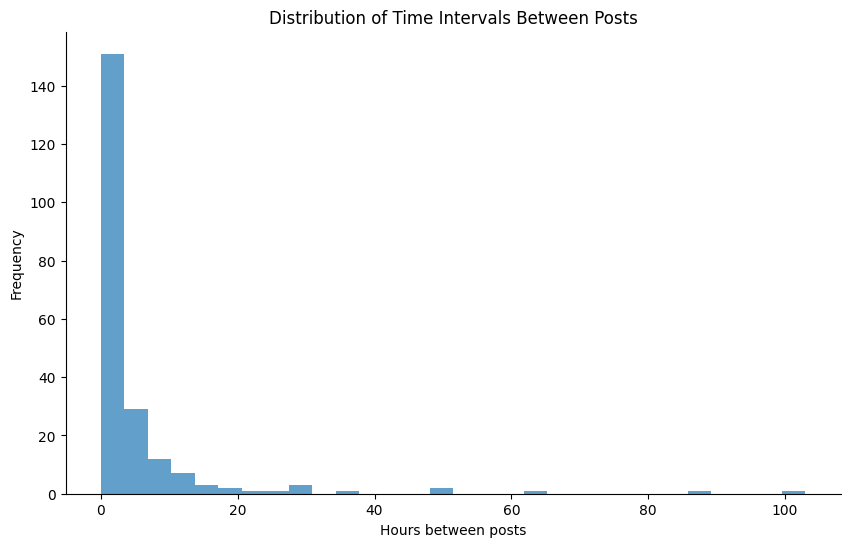

In [27]:
# Overall time intervals analysis
print("=== OVERALL TIME INTERVALS ===")
overall_intervals = basic.analyze_time_intervals(df, by_player=False)
print(f"Mean interval: {overall_intervals['overall']['mean_hours']:.2f} hours")
print(f"Median interval: {overall_intervals['overall']['median_hours']:.2f} hours")

# Plot overall intervals
plt.figure(figsize=(10, 6))
intervals_data = overall_intervals['overall']['intervals_data']
plt.hist(intervals_data, bins=30, alpha=0.7, edgecolor='none', linewidth=0.5)
plt.title('Distribution of Time Intervals Between Posts')
plt.xlabel('Hours between posts')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
save_plot('time_intervals_overall.png')
plt.show()


=== TIME INTERVALS BY PLAYER ===
LightSpeed: 20.62 hours (median: 9.32h, n=52)
AmazingAmazon: 24.87 hours (median: 12.37h, n=43)
ShyVideoGamer: 26.98 hours (median: 14.88h, n=40)
JacWalke: 25.82 hours (median: 15.78h, n=41)
Finny: 31.37 hours (median: 17.14h, n=34)
Saved: plots/time_intervals_by_player.png


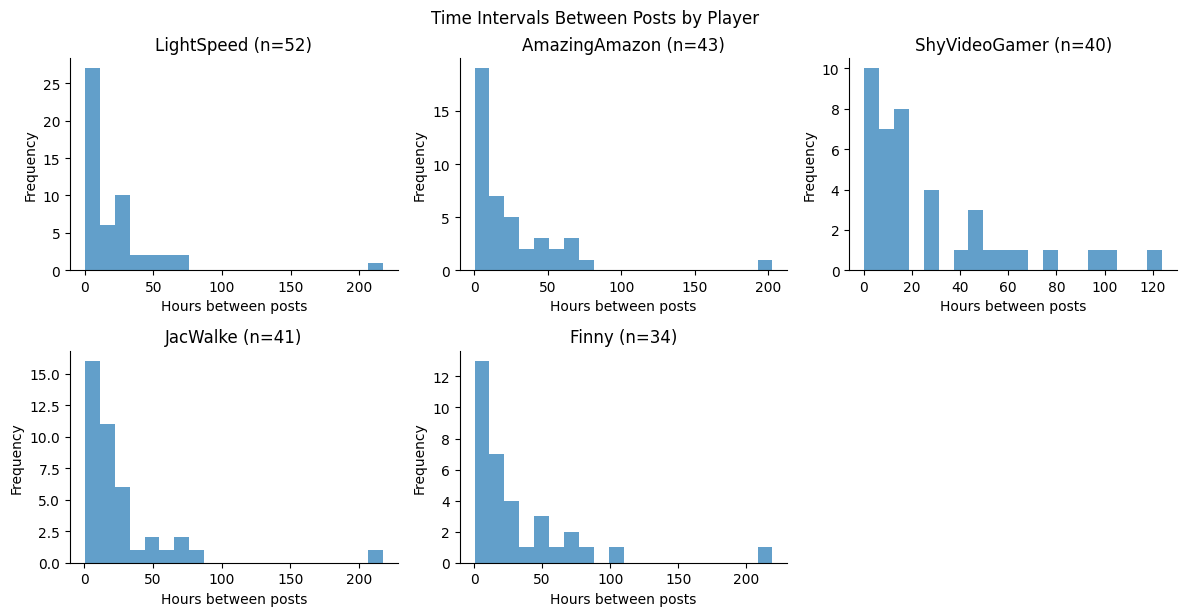

In [28]:
# Time intervals by player
print("\n=== TIME INTERVALS BY PLAYER ===")
player_intervals = basic.analyze_time_intervals(df, by_player=True)

# Print statistics for all players
for player, stats in player_intervals.items():
    print(f"{player}: {stats['mean_hours']:.2f} hours (median: {stats['median_hours']:.2f}h, n={stats['count']})")

# Plot intervals by player - create subplots based on number of players
if len(player_intervals) > 0:
    n_players = len(player_intervals)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()
    
    for i, (player, stats) in enumerate(player_intervals.items()):
        intervals_data = stats['intervals_data']
        axes[i].hist(intervals_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Hours between posts')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Time Intervals Between Posts by Player', y=1.02)
    save_plot('time_intervals_by_player.png')
    plt.show()

## Cumulative Post Analysis {#cumulative}

Track how posting activity accumulates over time, both overall and per player.

=== CUMULATIVE POSTS OVER TIME ===
Total posts in dataset: 216
Saved: plots/cumulative_posts_overall.png


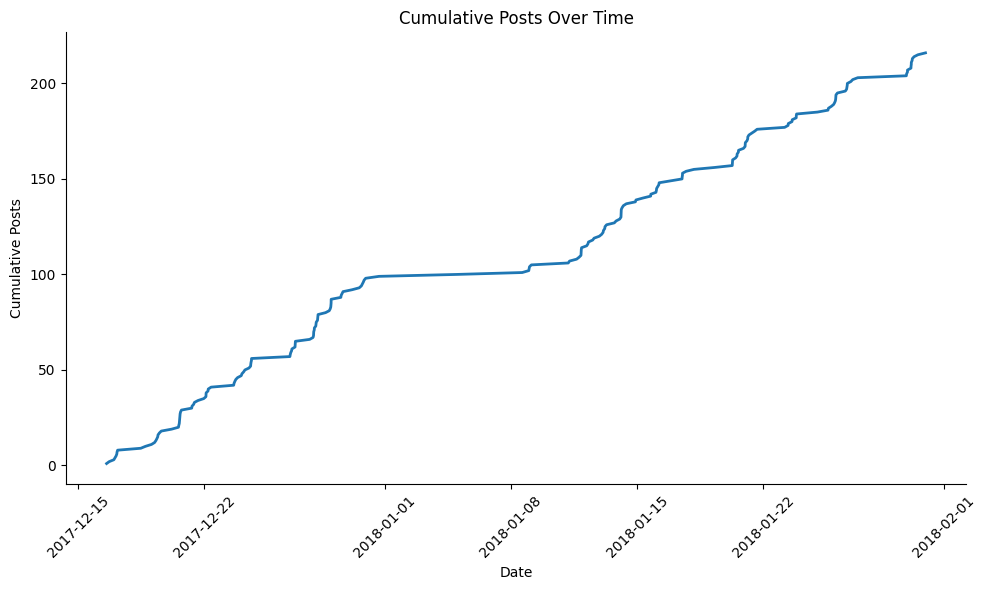

In [29]:
# Overall cumulative posts
print("=== CUMULATIVE POSTS OVER TIME ===")
cumulative_overall = basic.analyze_cumulative_posts(df, by_player=False)
print(f"Total posts in dataset: {len(cumulative_overall['cumulative_posts'])}")

# Plot overall cumulative posts
plt.figure(figsize=(10, 6))
plt.plot(cumulative_overall['dates'], cumulative_overall['cumulative_posts'], linewidth=2)
plt.title('Cumulative Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Posts')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('cumulative_posts_overall.png')
plt.show()


=== CUMULATIVE POSTS BY PLAYER ===
Final post counts by player:
  LightSpeed: 53 posts
  AmazingAmazon: 44 posts
  JacWalke: 42 posts
  ShyVideoGamer: 41 posts
  Finny: 35 posts
Saved: plots/cumulative_posts_by_player.png


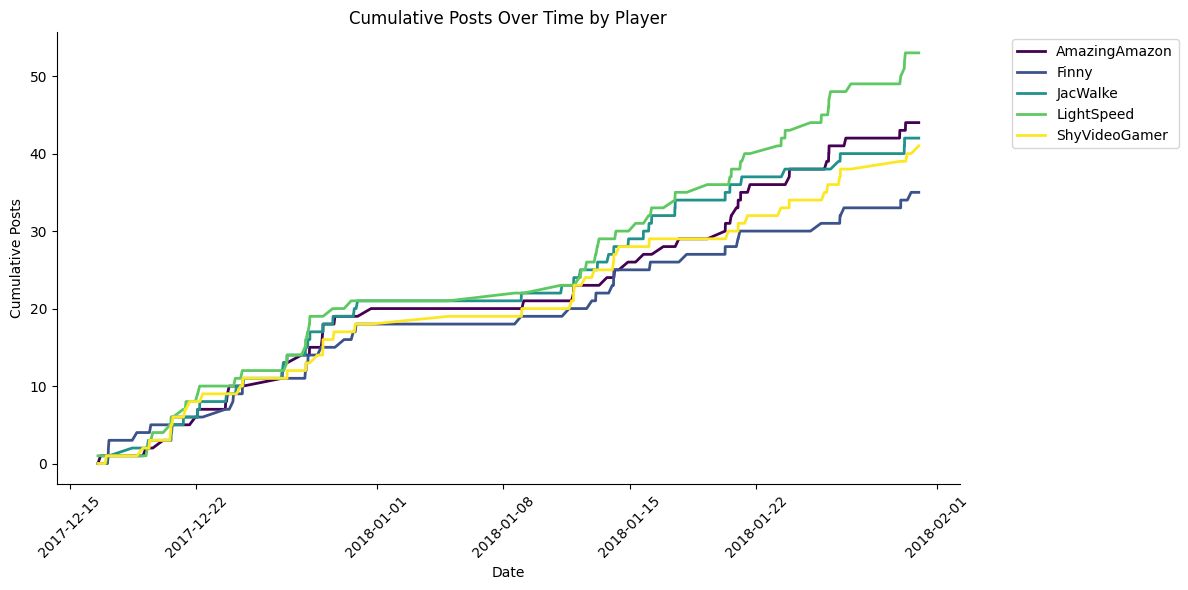

In [30]:
# Cumulative posts by player
print("\n=== CUMULATIVE POSTS BY PLAYER ===")
cumulative_by_player = basic.analyze_cumulative_posts(df, by_player=True)

if cumulative_by_player['type'] == 'by_player':
    # Print final counts
    final_counts = cumulative_by_player['data'].iloc[-1]
    print(f"Final post counts by player:")
    for player, count in final_counts.sort_values(ascending=False).head(10).items():
        print(f"  {player}: {count} posts")
    
    players      = cumulative_by_player['players']
    n_players    = len(players)
    cmap         = cm.get_cmap("viridis", n_players)          # perceptual colormap
    colours      = cmap(np.linspace(0, 1, n_players))         # N evenly-spaced colours

    # Plot cumulative posts by player
    plt.figure(figsize=(12, 6))
    for player in cumulative_by_player['players']:
        plt.plot(cumulative_by_player['dates'], cumulative_by_player['data'][player], 
                label=player, linewidth=2, color=colours[players.index(player)])
    
    plt.title('Cumulative Posts Over Time by Player')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Posts')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('cumulative_posts_by_player.png')
    plt.show()

## Player and Character Growth {#growth}

Analyze how the number of unique players and characters grows over the campaign timeline.

=== PLAYER AND CHARACTER GROWTH ===
Final unique players: 6
Final unique characters: 5

Growth milestones:
  First day: 1 players, 1 characters
  Midpoint: 6 players, 5 characters
  Final: 6 players, 5 characters
Saved: plots/unique_players_characters.png


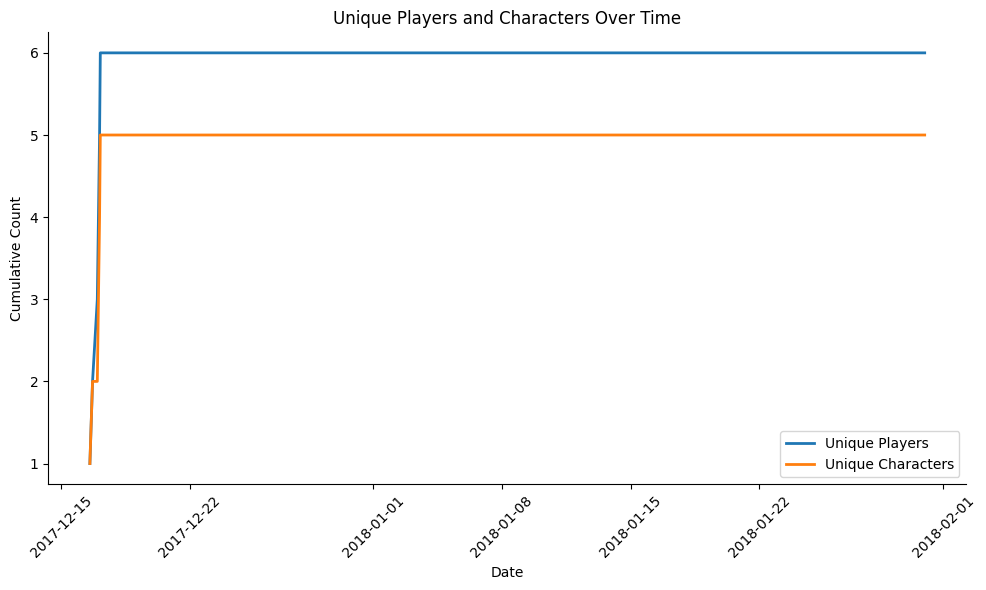

In [31]:
# Unique players and characters over time
print("=== PLAYER AND CHARACTER GROWTH ===")
growth_data = basic.analyze_unique_players_characters(df)
print(f"Final unique players: {growth_data['final_unique_players']}")
print(f"Final unique characters: {growth_data['final_unique_characters']}")

# Show growth milestones
unique_players = growth_data['unique_players_cumulative']
unique_characters = growth_data['unique_characters_cumulative']
print(f"\nGrowth milestones:")
print(f"  First day: {unique_players[0]} players, {unique_characters[0]} characters")
print(f"  Midpoint: {unique_players[len(unique_players)//2]} players, {unique_characters[len(unique_characters)//2]} characters")
print(f"  Final: {unique_players[-1]} players, {unique_characters[-1]} characters")

# Plot unique players and characters growth
plt.figure(figsize=(10, 6))
plt.plot(growth_data['dates'], growth_data['unique_players_cumulative'], 
         label='Unique Players', linewidth=2)
plt.plot(growth_data['dates'], growth_data['unique_characters_cumulative'], 
         label='Unique Characters', linewidth=2)
plt.title('Unique Players and Characters Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('unique_players_characters.png')
plt.show()

## Post Length Analysis {#lengths}

Examine the distribution of post lengths (word counts) to understand communication patterns.

=== OVERALL POST LENGTH STATISTICS ===
Mean words per post: 93.8
Median words per post: 53.5
Standard deviation: 117.8
Longest post: 1114 words
Saved: plots/post_lengths_overall.png


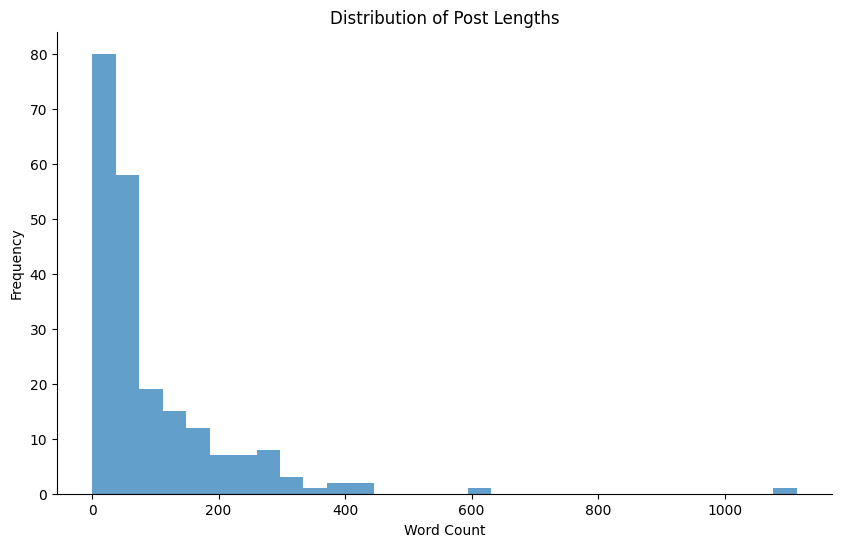

In [32]:
# Overall post length analysis
print("=== OVERALL POST LENGTH STATISTICS ===")
overall_lengths = basic.analyze_post_lengths(df, by_player=False)
stats = overall_lengths['overall']
print(f"Mean words per post: {stats['mean_words']:.1f}")
print(f"Median words per post: {stats['median_words']:.1f}")
print(f"Standard deviation: {stats['std_words']:.1f}")
print(f"Longest post: {stats['max_words']} words")

# Plot overall post lengths
plt.figure(figsize=(10, 6))
word_counts_data = stats['word_counts_data']
plt.hist(word_counts_data, bins=30, alpha=0.7, edgecolor='none', linewidth=0.5)
plt.title('Distribution of Post Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
save_plot('post_lengths_overall.png')
plt.show()


=== POST LENGTH BY ALL PLAYERS ===
LightSpeed: 147.7 words average (n=53)
AmazingAmazon: 60.3 words average (n=44)
fromshus: 149.0 words average (n=1)
ShyVideoGamer: 77.3 words average (n=41)
JacWalke: 93.6 words average (n=42)
Finny: 72.2 words average (n=35)
Saved: plots/post_lengths_by_player.png


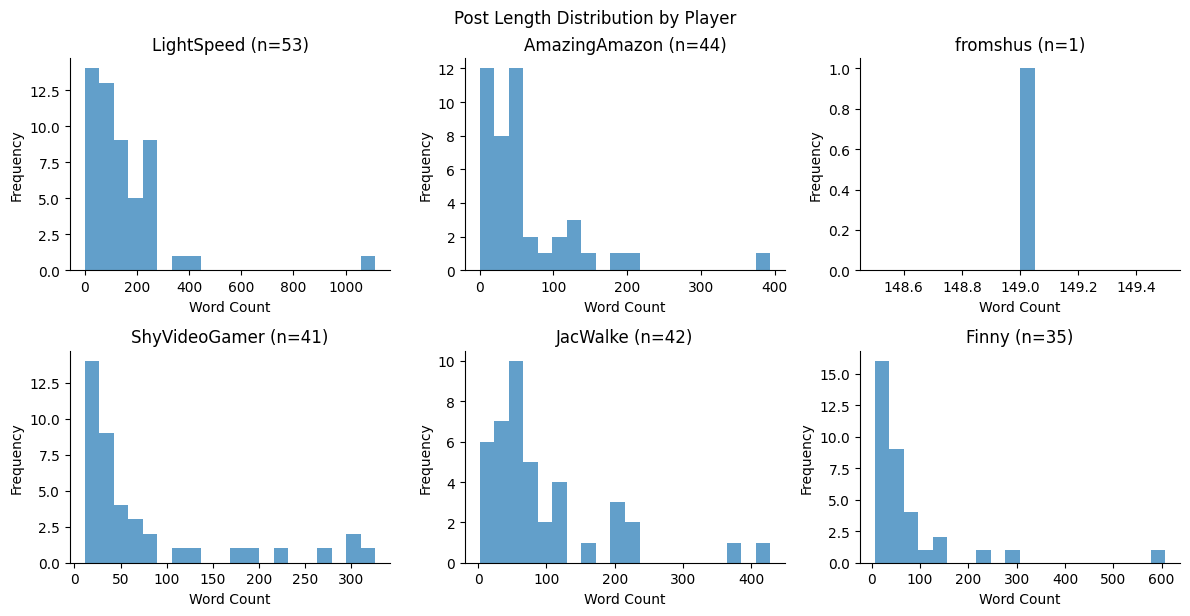

In [33]:
# Post length by player
print("\n=== POST LENGTH BY ALL PLAYERS ===")
player_lengths = basic.analyze_post_lengths(df, by_player=True)

# Print statistics for all players
for player, stats in player_lengths.items():
    if player != 'overall':
        print(f"{player}: {stats['mean_words']:.1f} words average (n={stats['count']})")

# Plot post lengths by player - create subplots based on number of players
if len(player_lengths) > 0:
    n_players = len(player_lengths)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()

    for i, (player, stats) in enumerate(player_lengths.items()):
        word_counts_data = stats['word_counts_data']
        axes[i].hist(word_counts_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Post Length Distribution by Player', y=1.02)
    save_plot('post_lengths_by_player.png')
    plt.show()

## Paragraph Action Analysis {#action-analysis}

**NEW: Integrated Classification in load_dnd_data()**

The `load_dnd_data()` function now automatically classifies messages and paragraphs, including:
- **Message types**: action, dialogue, narrative (added to DataFrame as `message_type` column)
- **Character labels**: in-character, out-of-character, mixed (separated text in `in_character_text`, `out_of_character_text`, `mixed_text` columns)
- **Dice roll detection**: automatically detected (added as `has_dice_roll` boolean column)
- **Paragraph-level actions**: name mentions, spells, dialogue, rolls, weapon actions (processed during data loading)

The analysis below shows paragraph-level action types based on the actual data structure: name_mentions, spells, dialogue, roll, weapon actions, and character labels.

=== PARAGRAPH ACTION ANALYSIS - TIME SERIES ===
📋 Using integrated classification from load_dnd_data() function
Total paragraphs: 167

🎬 ACTION TYPE DISTRIBUTION:
  Name mentions: 4 (2.4%)
  Spells: 1 (0.6%)
  Dialogue: 1 (0.6%)
  Rolls/Checks: 0 (0.0%)
  Weapon/Combat: 0 (0.0%)
  No action: 163 (97.6%)

🎭 CHARACTER LABEL DISTRIBUTION:
  In-character: 154 (92.2%)
  Out-of-character: 10 (6.0%)
  Mixed: 0 paragraphs
  Unlabeled: 3 paragraphs

📈 Creating time series from daily_data...
Saved: plots/paragraph_action_timeseries.png


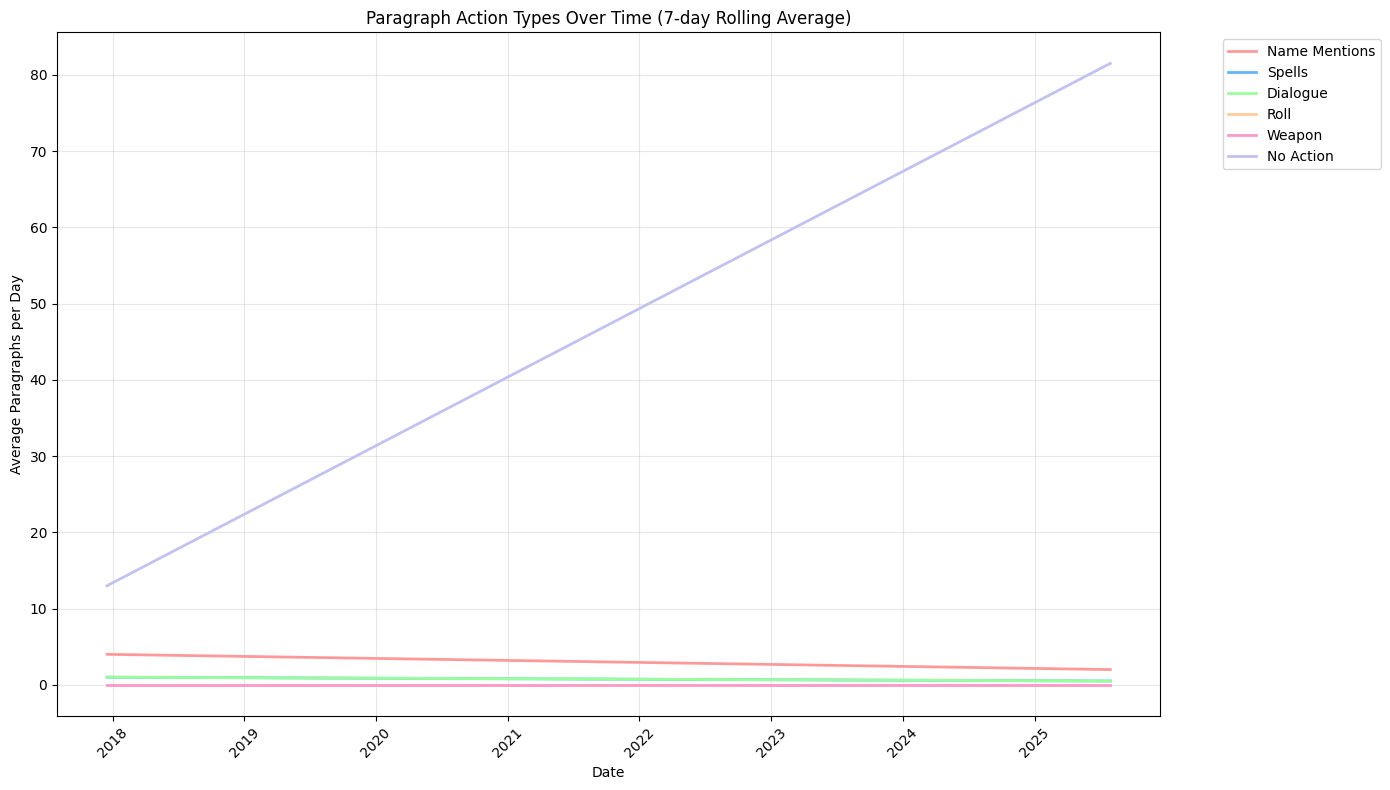

📊 Time series plot created with 6 action types
   Date range: 2017-12-16 to 2025-07-30
   Total data points: 2


In [20]:
# Paragraph Action Analysis - Time Series
print("=== PARAGRAPH ACTION ANALYSIS - TIME SERIES ===")
print("📋 Using integrated classification from load_dnd_data() function")

# Use the new function that analyzes paragraph-level actions
# This function now leverages the classification logic integrated into load_dnd_data()
action_data = basic.analyze_paragraph_actions(selected_campaign_data)

print(f"Total paragraphs: {action_data['total_paragraphs']}")
print(f"\n🎬 ACTION TYPE DISTRIBUTION:")
print(f"  Name mentions: {action_data['name_mentions_paragraphs']} ({action_data['name_mentions_percentage']:.1f}%)")
print(f"  Spells: {action_data['spells_paragraphs']} ({action_data['spells_percentage']:.1f}%)")
print(f"  Dialogue: {action_data['dialogue_paragraphs']} ({action_data['dialogue_percentage']:.1f}%)")
print(f"  Rolls/Checks: {action_data['roll_paragraphs']} ({action_data['roll_percentage']:.1f}%)")
print(f"  Weapon/Combat: {action_data['weapon_paragraphs']} ({action_data['weapon_percentage']:.1f}%)")
print(f"  No action: {action_data['no_action_paragraphs']} ({action_data['no_action_percentage']:.1f}%)")

print(f"\n🎭 CHARACTER LABEL DISTRIBUTION:")
print(f"  In-character: {action_data['in_character_paragraphs']} ({action_data['in_character_percentage']:.1f}%)")
print(f"  Out-of-character: {action_data['out_of_character_paragraphs']} ({action_data['out_of_character_percentage']:.1f}%)")
print(f"  Mixed: {action_data['mixed_paragraphs']} paragraphs")
print(f"  Unlabeled: {action_data['unlabeled_paragraphs']} paragraphs")

# Create time series using the daily_data from analyze_paragraph_actions
if 'daily_data' in action_data and action_data['daily_data']:
    print("\n📈 Creating time series from daily_data...")
    
    daily_data = action_data['daily_data']
    dates = sorted(daily_data.keys())
    
    # Create DataFrame for easier manipulation
    time_series_data = []
    for date in dates:
        date_data = daily_data[date]
        for action_type, count in date_data.items():
            time_series_data.append({
                'date': pd.to_datetime(date),
                'action_type': action_type,
                'count': count
            })
    
    if time_series_data:
        ts_df = pd.DataFrame(time_series_data)
        
        # Create pivot table for plotting
        pivot_df = ts_df.pivot(index='date', columns='action_type', values='count').fillna(0)
        
        # Calculate rolling averages (7-day window)
        window_days = 7
        rolling_df = pivot_df.rolling(window=window_days, min_periods=1).mean()
        
        # Time Series Plot
        plt.figure(figsize=(14, 8))
        
        action_types = ['name_mentions', 'spells', 'dialogue', 'roll', 'weapon', 'no_action']
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']
        line_styles = ['-', '-', '-', '-', '-', '-']
        
        plotted_count = 0
        for i, action_type in enumerate(action_types):
            if action_type in rolling_df.columns:
                plt.plot(rolling_df.index, rolling_df[action_type], 
                        label=f'{action_type.replace("_", " ").title()}', 
                        linewidth=2, color=colors[i], linestyle=line_styles[i])
                plotted_count += 1
        
        plt.xlabel('Date')
        plt.ylabel('Average Paragraphs per Day')
        plt.title(f'Paragraph Action Types Over Time ({window_days}-day Rolling Average)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        save_plot('paragraph_action_timeseries.png')
        plt.show()
        
        print(f"📊 Time series plot created with {plotted_count} action types")
        print(f"   Date range: {rolling_df.index.min().date()} to {rolling_df.index.max().date()}")
        print(f"   Total data points: {len(rolling_df)}")
        
    else:
        print("⚠️  No time series data created - check daily_data processing")
        
else:
    print("⚠️  No daily_data available for time series analysis")
    print("   This indicates the paragraph action analysis found no paragraph data")
    
    # Fallback: Create a simple time series based on message-level data from DataFrame
    print("\n📈 Creating fallback time series from DataFrame message data...")
    
    # Use the already-classified DataFrame data
    msg_df = df[['date', 'message_type']].copy()
    msg_df = msg_df.sort_values('date')
    
    # Group by date and count message types
    daily_counts = msg_df.groupby([msg_df['date'].dt.date, 'message_type']).size().unstack(fill_value=0)
    
    # Calculate rolling averages
    window_days = 7
    rolling_counts = daily_counts.rolling(window=window_days, min_periods=1).mean()
    
    # Time Series Plot
    plt.figure(figsize=(14, 8))
    
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']
    
    for i, message_type in enumerate(rolling_counts.columns):
        plt.plot(rolling_counts.index, rolling_counts[message_type], 
                label=f'{message_type.replace("_", " ").title()}', 
                linewidth=2, color=colors[i % len(colors)])
    
    plt.xlabel('Date')
    plt.ylabel('Average Messages per Day')
    plt.title(f'Message Types Over Time ({window_days}-day Rolling Average)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('message_type_timeseries.png')
    plt.show()


## Character Mention Analysis {#mentions}

Identify the most frequently mentioned character names to understand story focus and important NPCs.

In [21]:
# Character mention analysis
print("=== CHARACTER MENTION ANALYSIS ===")
mention_data = basic.analyze_character_mentions(df, top_n=15)

print(f"Total mentions: {mention_data['total_mentions']}")
print(f"Unique characters mentioned: {mention_data['unique_characters_mentioned']}")

print(f"\nTop 10 most mentioned characters:")
for i, (character, count) in enumerate(list(mention_data['top_mentions'].items())[:10], 1):
    print(f"  {i:2d}. {character}: {count} mentions")

# Plot character mentions
if len(mention_data['top_mentions_names']) > 0:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(mention_data['top_mentions_names'])), 
                   mention_data['top_mentions_counts'], alpha=0.7)
    plt.title(f'Top {len(mention_data["top_mentions_names"])} Most Mentioned Characters')
    plt.xlabel('Character Name')
    plt.ylabel('Mention Count')
    plt.xticks(range(len(mention_data['top_mentions_names'])), 
               mention_data['top_mentions_names'], rotation=45, ha='right')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bar, value in zip(bars, mention_data['top_mentions_counts']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(value), ha='center', va='bottom')
    
    plt.tight_layout()
    save_plot('character_mentions.png')
    plt.show()

=== CHARACTER MENTION ANALYSIS ===
Total mentions: 0
Unique characters mentioned: 0

Top 10 most mentioned characters:


## Dice Roll Analysis {#dice-rolls}

Analyze the frequency of dice rolls to understand mechanical vs. narrative gameplay balance.

=== DICE ROLL ANALYSIS ===
Total posts: 151
Posts with dice rolls: 4 (2.6%)

Dice roll frequency by player:
  Finny: 2/26 posts (7.7%)
  LightSpeed: 2/35 posts (5.7%)
  AmazingAmazon: 0/28 posts (0.0%)
  JacWalke: 0/33 posts (0.0%)
  ShyVideoGamer: 0/29 posts (0.0%)
Saved: plots/dice_roll_frequency.png


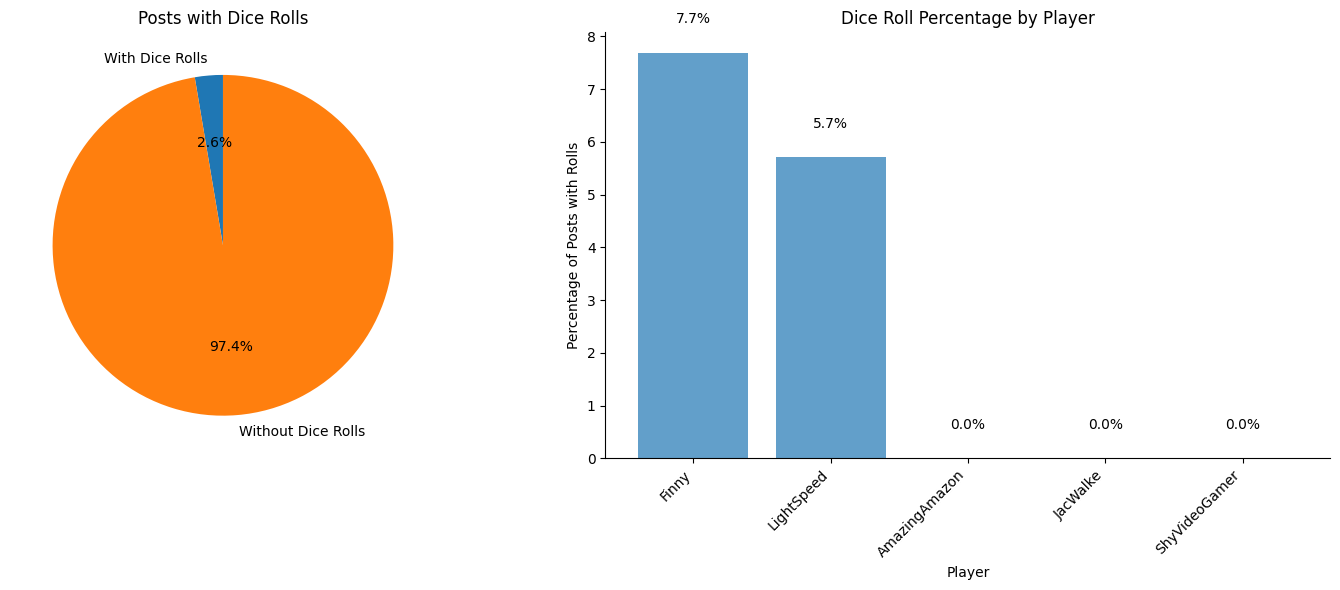

Saved: plots/dice_roll_timeseries.png


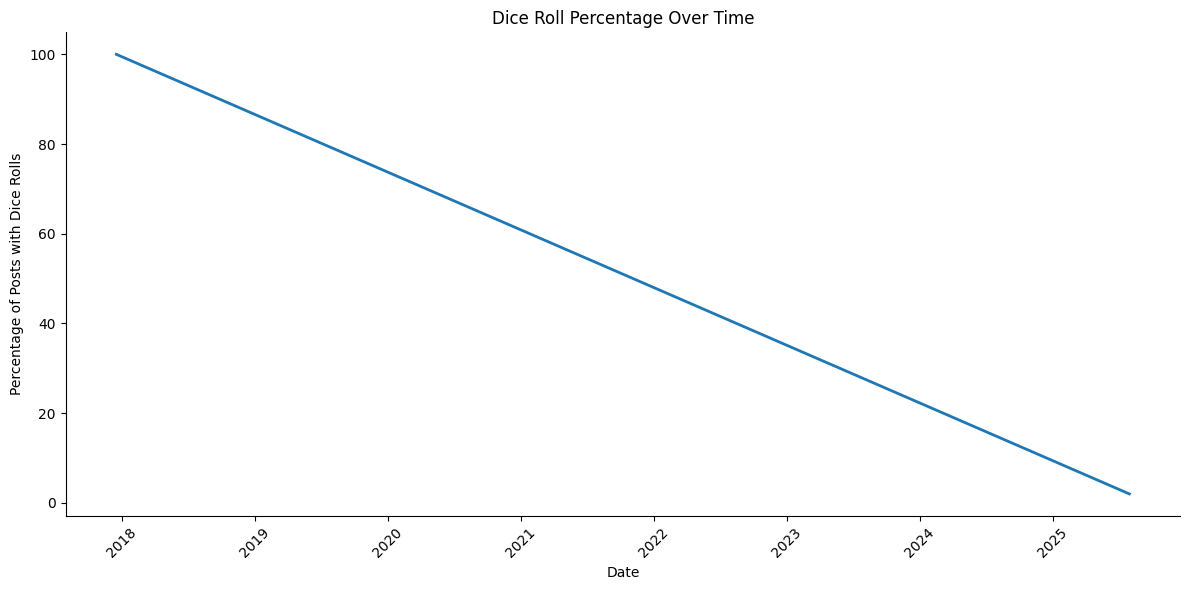

In [22]:
# Dice roll analysis
print("=== DICE ROLL ANALYSIS ===")
dice_data = basic.analyze_dice_roll_frequency(df)

print(f"Total posts: {dice_data['total_posts']}")
print(f"Posts with dice rolls: {dice_data['posts_with_rolls']} ({dice_data['roll_percentage']:.1f}%)")

print(f"\nDice roll frequency by player:")
for player_stat in dice_data['player_stats']:
    player = player_stat['player']
    percentage = player_stat['percentage']
    count = player_stat['count']
    rolls = player_stat['sum']
    print(f"  {player}: {rolls}/{count} posts ({percentage:.1f}%)")

# Create dice roll visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall pie chart
ax1.pie([dice_data['posts_with_rolls'], dice_data['posts_without_rolls']], 
        labels=['With Dice Rolls', 'Without Dice Rolls'],
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Posts with Dice Rolls')

# Dice roll percentage by player
if len(dice_data['player_names']) > 0:
    bars = ax2.bar(range(len(dice_data['player_names'])), 
                   dice_data['player_percentages'], alpha=0.7)
    ax2.set_title('Dice Roll Percentage by Player')
    ax2.set_xlabel('Player')
    ax2.set_ylabel('Percentage of Posts with Rolls')
    ax2.set_xticks(range(len(dice_data['player_names'])))
    ax2.set_xticklabels(dice_data['player_names'], rotation=45, ha='right')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add value labels
    for bar, value in zip(bars, dice_data['player_percentages']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
save_plot('dice_roll_frequency.png')
plt.show()

# Time series plot
if len(dice_data['daily_dates']) > 1:
    plt.figure(figsize=(12, 6))
    plt.plot(dice_data['daily_dates'], dice_data['daily_percentages'], linewidth=2)
    plt.title('Dice Roll Percentage Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Posts with Dice Rolls')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('dice_roll_timeseries.png')
    plt.show()

## Summary Report {#summary}

Generate a comprehensive overview of the entire campaign for quick insights.

In [23]:
# Generate comprehensive summary report
print("=== COMPREHENSIVE CAMPAIGN SUMMARY ===")
summary = basic.generate_summary_report(df)

print("\n📊 CAMPAIGN OVERVIEW")
overview = summary['campaign_overview']
print(f"  📅 Duration: {overview['date_range']}")
print(f"  📝 Total posts: {overview['total_posts']}")
print(f"  👥 Unique players: {overview['unique_players']}")
print(f"  🎭 Unique characters: {overview['unique_characters']}")
print(f"  📈 Posts per day: {overview['posts_per_day']:.1f}")

print("\n📝 POSTING PATTERNS")
patterns = summary['posting_patterns']
print(f"  🏆 Most active player: {patterns['most_active_player']} ({patterns['posts_by_most_active']} posts)")
print(f"  📏 Average post length: {patterns['average_post_length']:.1f} words")
print(f"  📚 Longest post: {patterns['longest_post_words']} words")

print("\n🎮 GAMEPLAY CHARACTERISTICS")
gameplay = summary['gameplay_characteristics']
print(f"  🎲 Dice roll frequency: {gameplay['dice_roll_percentage']:.1f}%")
print(f"  ⚔️ Action posts: {gameplay['action_percentage']:.1f}%")
print(f"  💬 Dialogue posts: {gameplay['dialogue_percentage']:.1f}%")
print(f"  ⚔️ Combat posts: {gameplay['combat_posts']} ({gameplay['combat_percentage']:.1f}%)")

print("\n✅ Analysis complete! All plots have been saved as PNG files.")

=== COMPREHENSIVE CAMPAIGN SUMMARY ===

📊 CAMPAIGN OVERVIEW
  📅 Duration: 2017-12-16 to 2025-07-30
  📝 Total posts: 151
  👥 Unique players: 5
  🎭 Unique characters: 5
  📈 Posts per day: 0.1

📝 POSTING PATTERNS
  🏆 Most active player: LightSpeed (35 posts)
  📏 Average post length: 207.0 words
  📚 Longest post: 1114 words

🎮 GAMEPLAY CHARACTERISTICS
  🎲 Dice roll frequency: 2.6%
  ⚔️ Action posts: 64.2%
  💬 Dialogue posts: 35.8%
  ⚔️ Combat posts: 0 (0.0%)

✅ Analysis complete! All plots have been saved as PNG files.
